## Guardians of the Crypto
### A Streamlit Application for Enhanced Price Prediction and Informed Decision-Making
###### by Mirna Philip, Justin Farnan and Arya Shahbazi

###### The cryptocurrency market is very unpredictable, with prices changing a lot in a short time, making it hard for investors and traders to make good decisions. Our project, Guardians of the Crypto, aims to solve this problem by using past price data and sentiment analysis to predict changes in cryptocurrency prices. By combining these methods, we want to create a reliable tool that helps traders and investors understand the market better and make confident decisions. Studies have shown that social media sentiment, especially from platforms like Reddit, can affect cryptocurrency prices. Our main goals are to collect past price data for major cryptocurrencies using the Coinbase API and gather sentiment data from Reddit using natural language processing (NLP) tools. We will clean and prepare this data, analyze Reddit posts to determine market sentiment, and train different machine learning models, including simple models like Linear Regression and advanced ones like Long Short-Term Memory (LSTM) networks, to predict cryptocurrency price changes accurately. We will evaluate these models, improve the best one, and develop a Streamlit application that combines sentiment analysis, past price data, and other trading metrics to help cryptocurrency traders and investors make better decisions in a volatile market.

In [48]:
#!pip install shap


In [49]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pytz
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import shap

#### Data Inspection and Understanding

In [4]:
# Load the data
file_path = 'RAW_Data/main_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print("First few rows of the dataset:")
data.head()

First few rows of the dataset:


,Unnamed: 0,time,low,high,open,close,volume,price_change,average_price,volatitlity,product_id
0,0,2021-12-27,50480.00,52100.00,50804.33,50717.77,11596.914682,-86.56,51290.000,3.209192,BTC-USD
1,1,2021-12-26,49460.00,51295.33,50428.31,50801.79,6863.394738,373.48,50377.665,3.710736,BTC-USD
2,2,2021-12-25,50191.84,51171.68,50852.31,50428.31,5550.571532,-424.00,50681.760,1.952190,BTC-USD
3,3,2021-12-24,50445.55,51878.60,50842.06,50851.38,11690.454182,9.32,51162.075,2.840786,BTC-USD
4,4,2021-12-23,48032.16,51397.82,48608.61,50842.20,16627.046280,2233.59,49714.990,7.007097,BTC-USD


In [21]:
def print_dataframe_shape(df, name):
    rows, columns = df.shape
    print(f"{name} database has {rows} rows and {columns} columns.")

print_dataframe_shape(data, "Cryptocurrency")

Cryptocurrency database has 6847 rows and 11 columns.


In [5]:
# Display basic information about the dataframe
print("\nBasic information about the dataset:")
data.info()


Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6847 entries, 0 to 6846
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     6847 non-null   int64  
 1   time           6847 non-null   object 
 2   low            6847 non-null   float64
 3   high           6847 non-null   float64
 4   open           6847 non-null   float64
 5   close          6847 non-null   float64
 6   volume         6847 non-null   float64
 7   price_change   6847 non-null   float64
 8   average_price  6847 non-null   float64
 9   volatitlity    6847 non-null   float64
 10  product_id     6847 non-null   object 
dtypes: float64(8), int64(1), object(2)
memory usage: 588.5+ KB


In [6]:
# Display summary statistics for the numerical columns
print("\nSummary statistics for the dataset:")
data.describe()


Summary statistics for the dataset:


,Unnamed: 0,low,high,open,close,volume,price_change,average_price,volatitlity
count,6847.000000,6847.000000,6847.00000,6847.000000,6847.000000,6.847000e+03,6847.000000,6847.000000,6847.000000
mean,3423.000000,6095.514346,6378.80187,6240.195701,6245.673744,1.379593e+07,5.478043,6237.158108,6.680400
std,1976.702979,14281.226704,14947.29766,14622.948569,14637.892078,3.361093e+07,484.456149,14612.664901,4.927680
min,0.000000,0.230000,0.24610,0.241900,0.242000,1.826040e+03,-5804.300000,0.242600,0.421154
25%,1711.500000,6.801000,7.27650,7.031500,7.031500,1.247476e+05,-1.250000,7.043500,3.656668
50%,3423.000000,66.150000,70.41000,68.360000,68.480000,6.557886e+05,0.000700,68.235000,5.503223
75%,5134.500000,1842.410000,1898.12500,1866.670000,1868.740000,3.618063e+06,1.400000,1867.937500,8.193763
max,6846.000000,71337.300000,73835.57000,73135.040000,73135.040000,4.214616e+08,5956.230000,72523.645000,103.887510


In [7]:
# Check for missing values
print("\nMissing values in the dataset:")
print(data.isnull().sum())


Missing values in the dataset:
Unnamed: 0       0
time             0
low              0
high             0
open             0
close            0
volume           0
price_change     0
average_price    0
volatitlity      0
product_id       0
dtype: int64


In [22]:
print("\nDuplicate values in the dataset:")
print(data.duplicated().sum())


Duplicate values in the dataset:
0


In [8]:
# Check the distribution of product IDs
print("\nDistribution of product IDs:")
print(data['product_id'].value_counts())



Distribution of product IDs:
product_id
BTC-USD     1084
ETH-USD     1084
SOL-USD     1084
ADA-USD     1084
LINK-USD    1084
LTC-USD     1084
XRP-USD      343
Name: count, dtype: int64


#### Exploratory Data Analysis (EDA)

In [9]:
# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'])

In [10]:
# Descriptive Statistics
print("Descriptive Statistics:")
data.describe()

Descriptive Statistics:


,Unnamed: 0,time,low,high,open,close,volume,price_change,average_price,volatitlity
count,6847.000000,6847,6847.000000,6847.00000,6847.000000,6847.000000,6.847000e+03,6847.000000,6847.000000,6847.000000
mean,3423.000000,2023-01-11 15:27:40.931794944,6095.514346,6378.80187,6240.195701,6245.673744,1.379593e+07,5.478043,6237.158108,6.680400
min,0.000000,2021-06-28 00:00:00,0.230000,0.24610,0.241900,0.242000,1.826040e+03,-5804.300000,0.242600,0.421154
25%,1711.500000,2022-04-10 00:00:00,6.801000,7.27650,7.031500,7.031500,1.247476e+05,-1.250000,7.043500,3.656668
50%,3423.000000,2023-01-22 00:00:00,66.150000,70.41000,68.360000,68.480000,6.557886e+05,0.000700,68.235000,5.503223
75%,5134.500000,2023-10-19 00:00:00,1842.410000,1898.12500,1866.670000,1868.740000,3.618063e+06,1.400000,1867.937500,8.193763
max,6846.000000,2024-06-20 00:00:00,71337.300000,73835.57000,73135.040000,73135.040000,4.214616e+08,5956.230000,72523.645000,103.887510
std,1976.702979,NaN,14281.226704,14947.29766,14622.948569,14637.892078,3.361093e+07,484.456149,14612.664901,4.927680


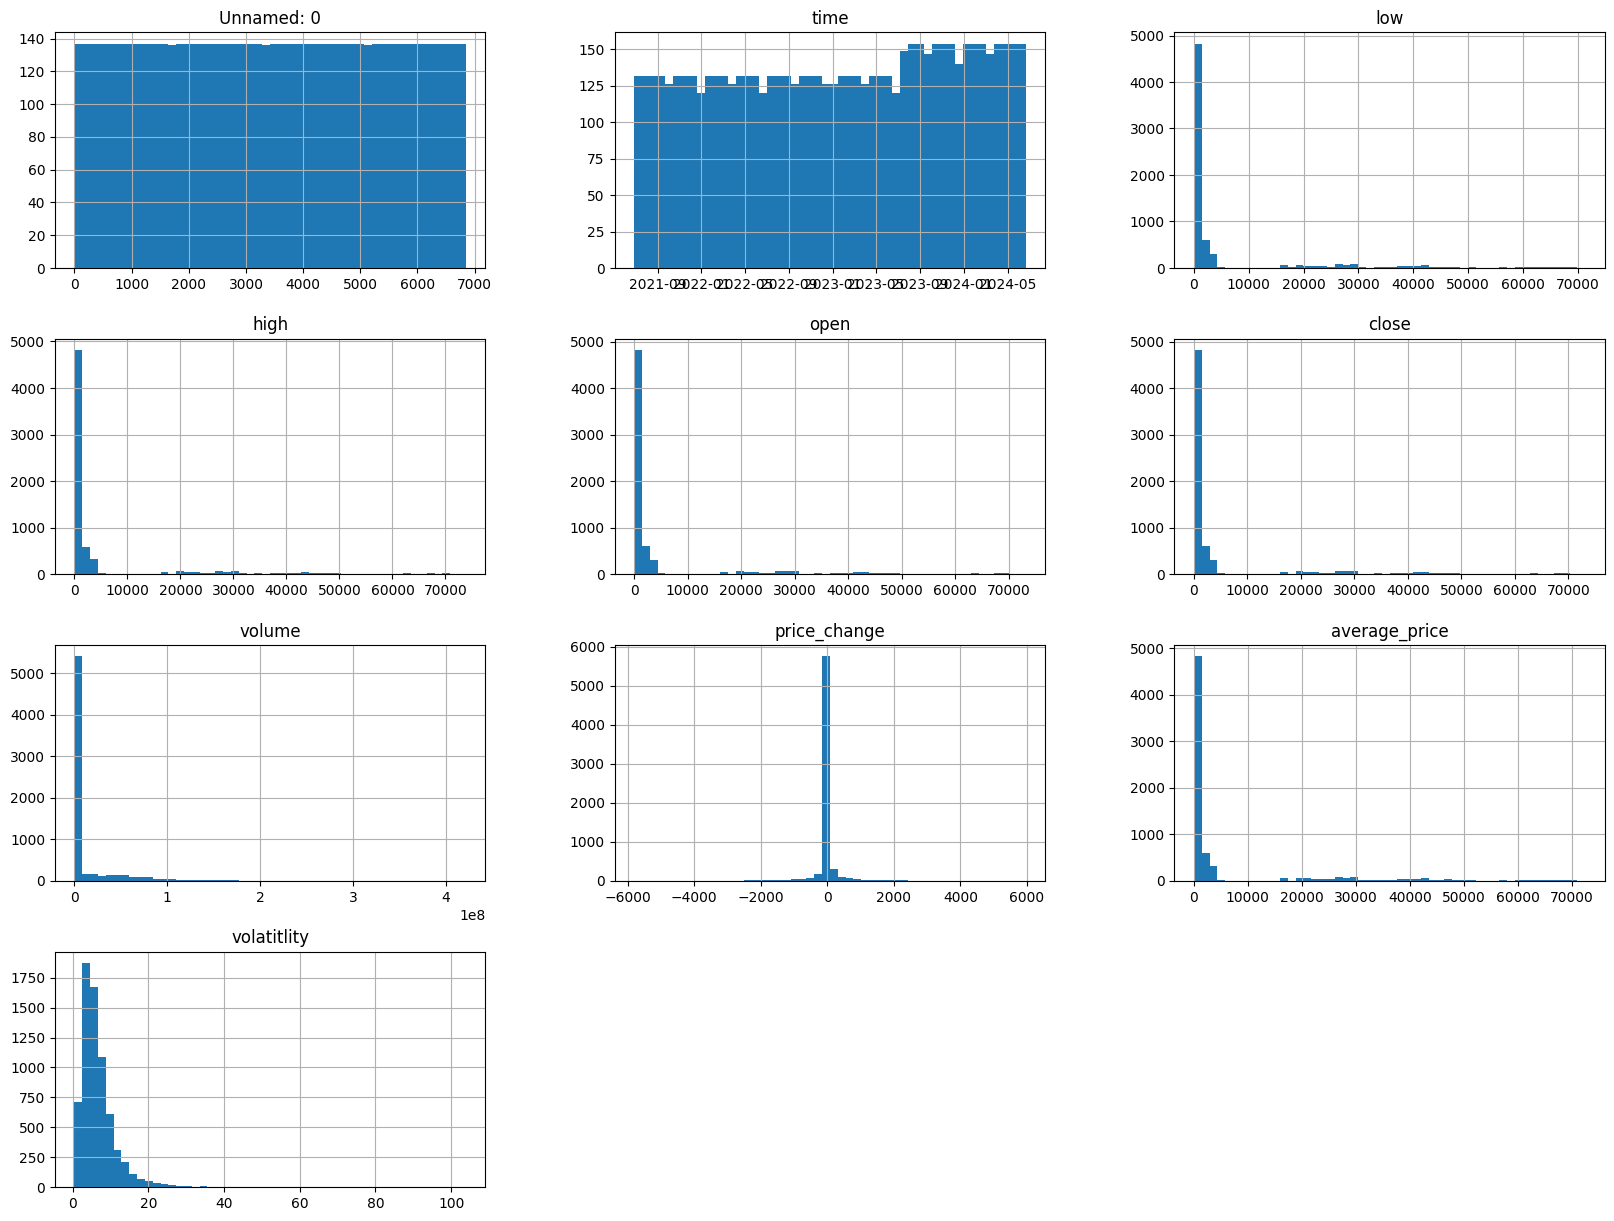

In [11]:
# Histograms
data.hist(bins=50, figsize=(20, 15))
plt.show()

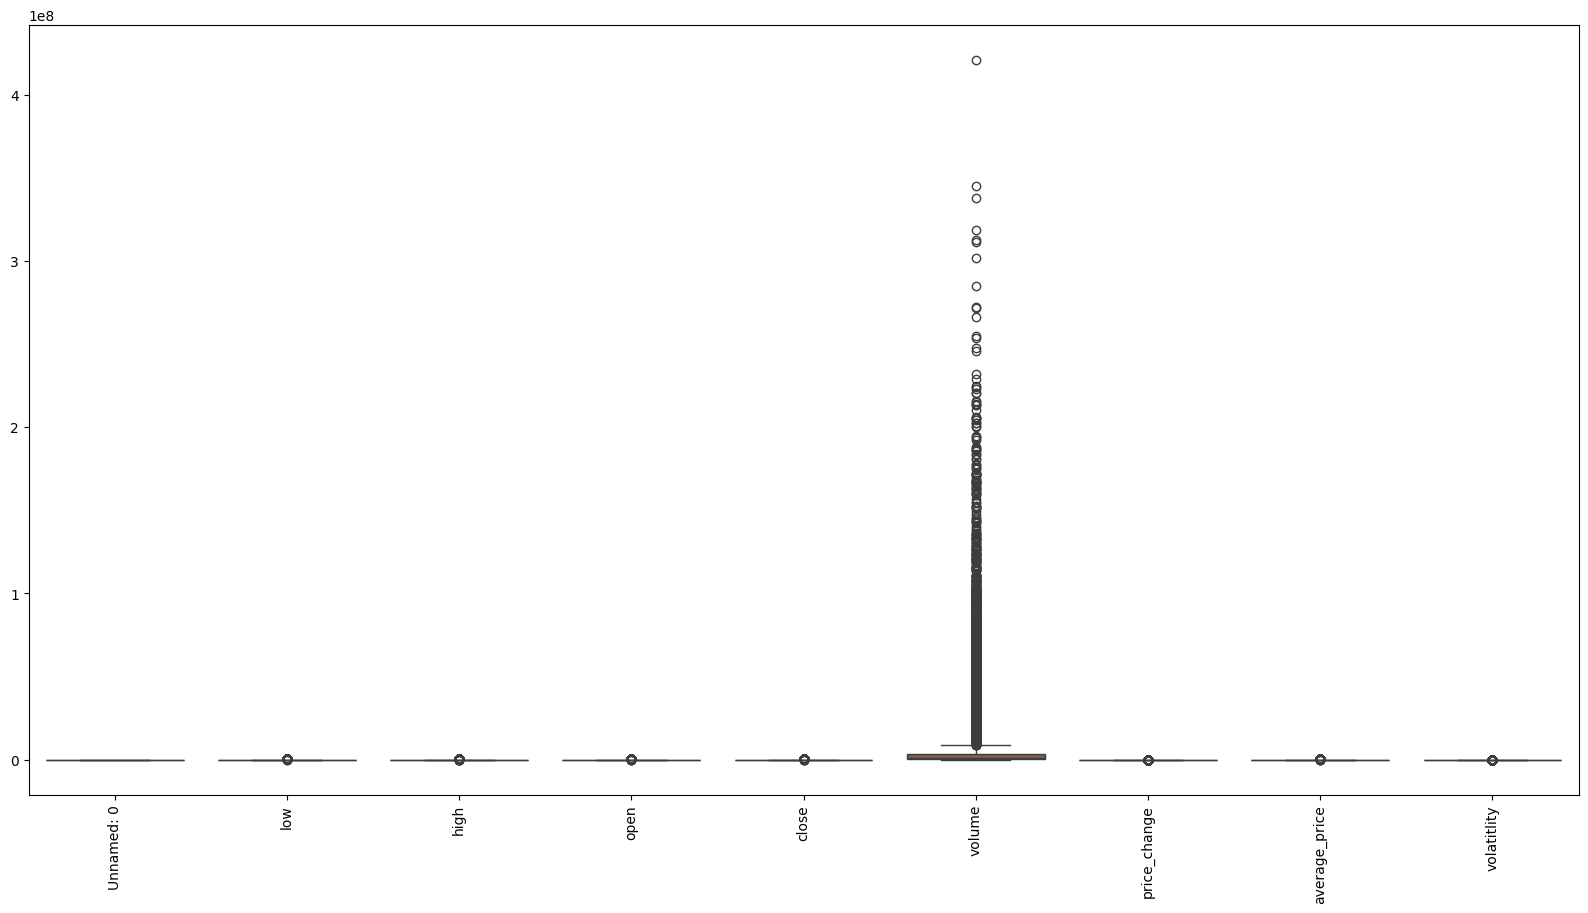

In [14]:
# Box plots
plt.figure(figsize=(20, 10))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.show()

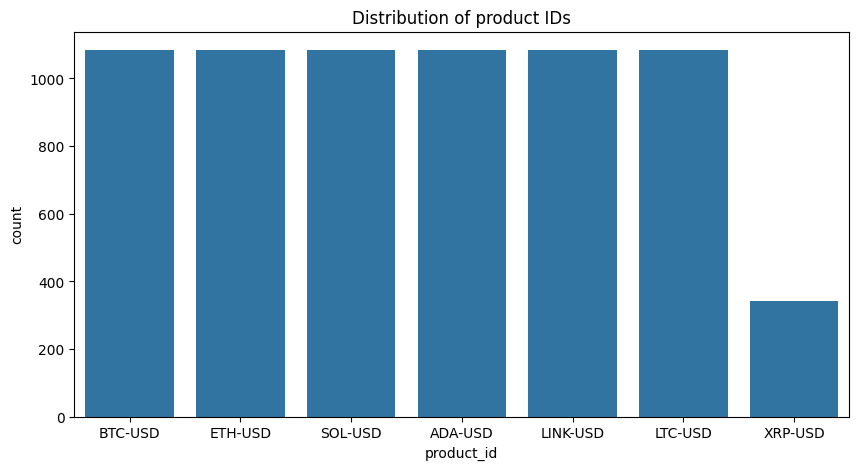

In [15]:
# Distribution of product IDs
plt.figure(figsize=(10, 5))
sns.countplot(x='product_id', data=data)
plt.title('Distribution of product IDs')
plt.show()

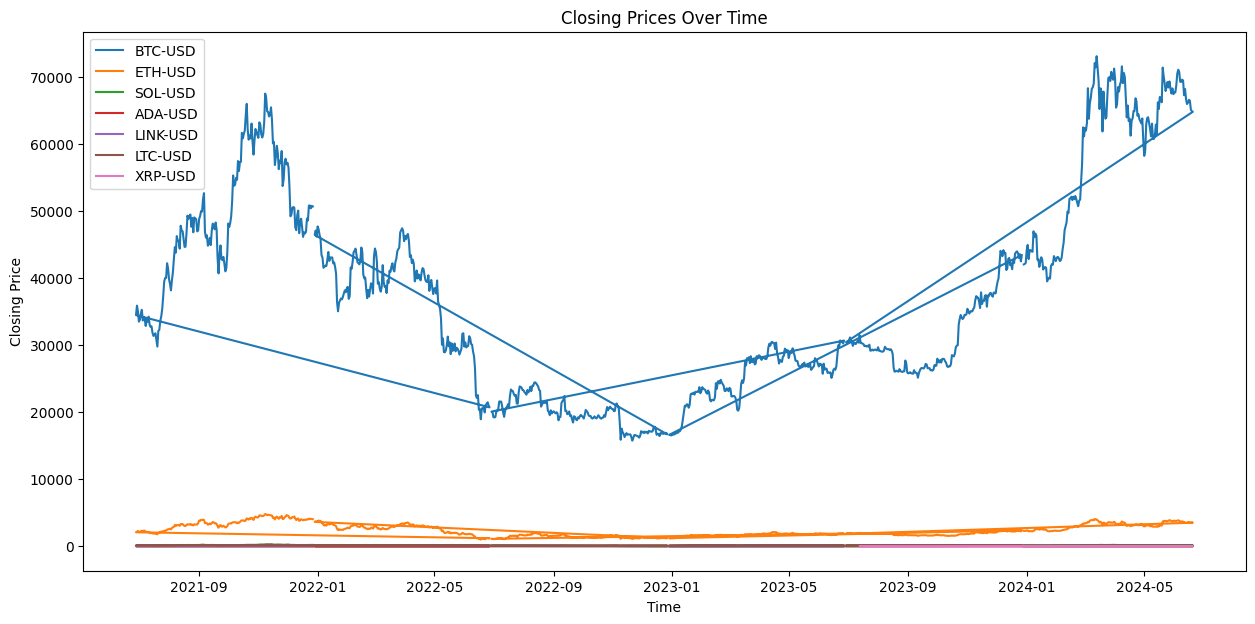

In [16]:
# Line plot for closing prices
plt.figure(figsize=(15, 7))
for product in data['product_id'].unique():
    product_data = data[data['product_id'] == product]
    plt.plot(product_data['time'], product_data['close'], label=product)
plt.title('Closing Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

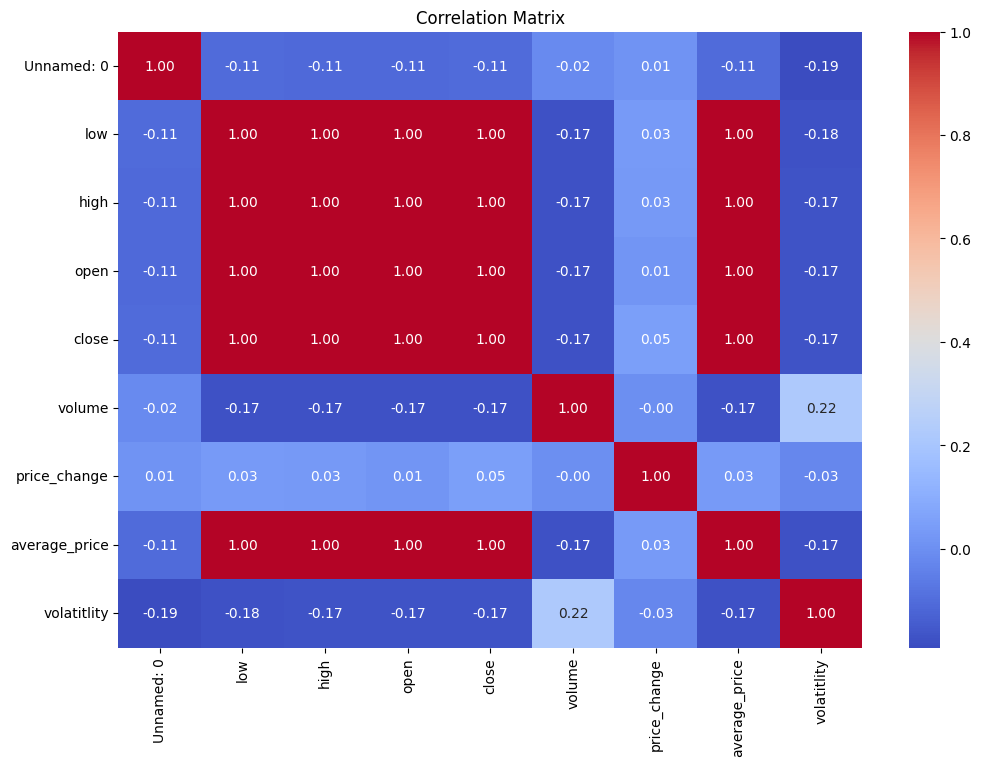

In [19]:
# Correlation Matrix excluding non-numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

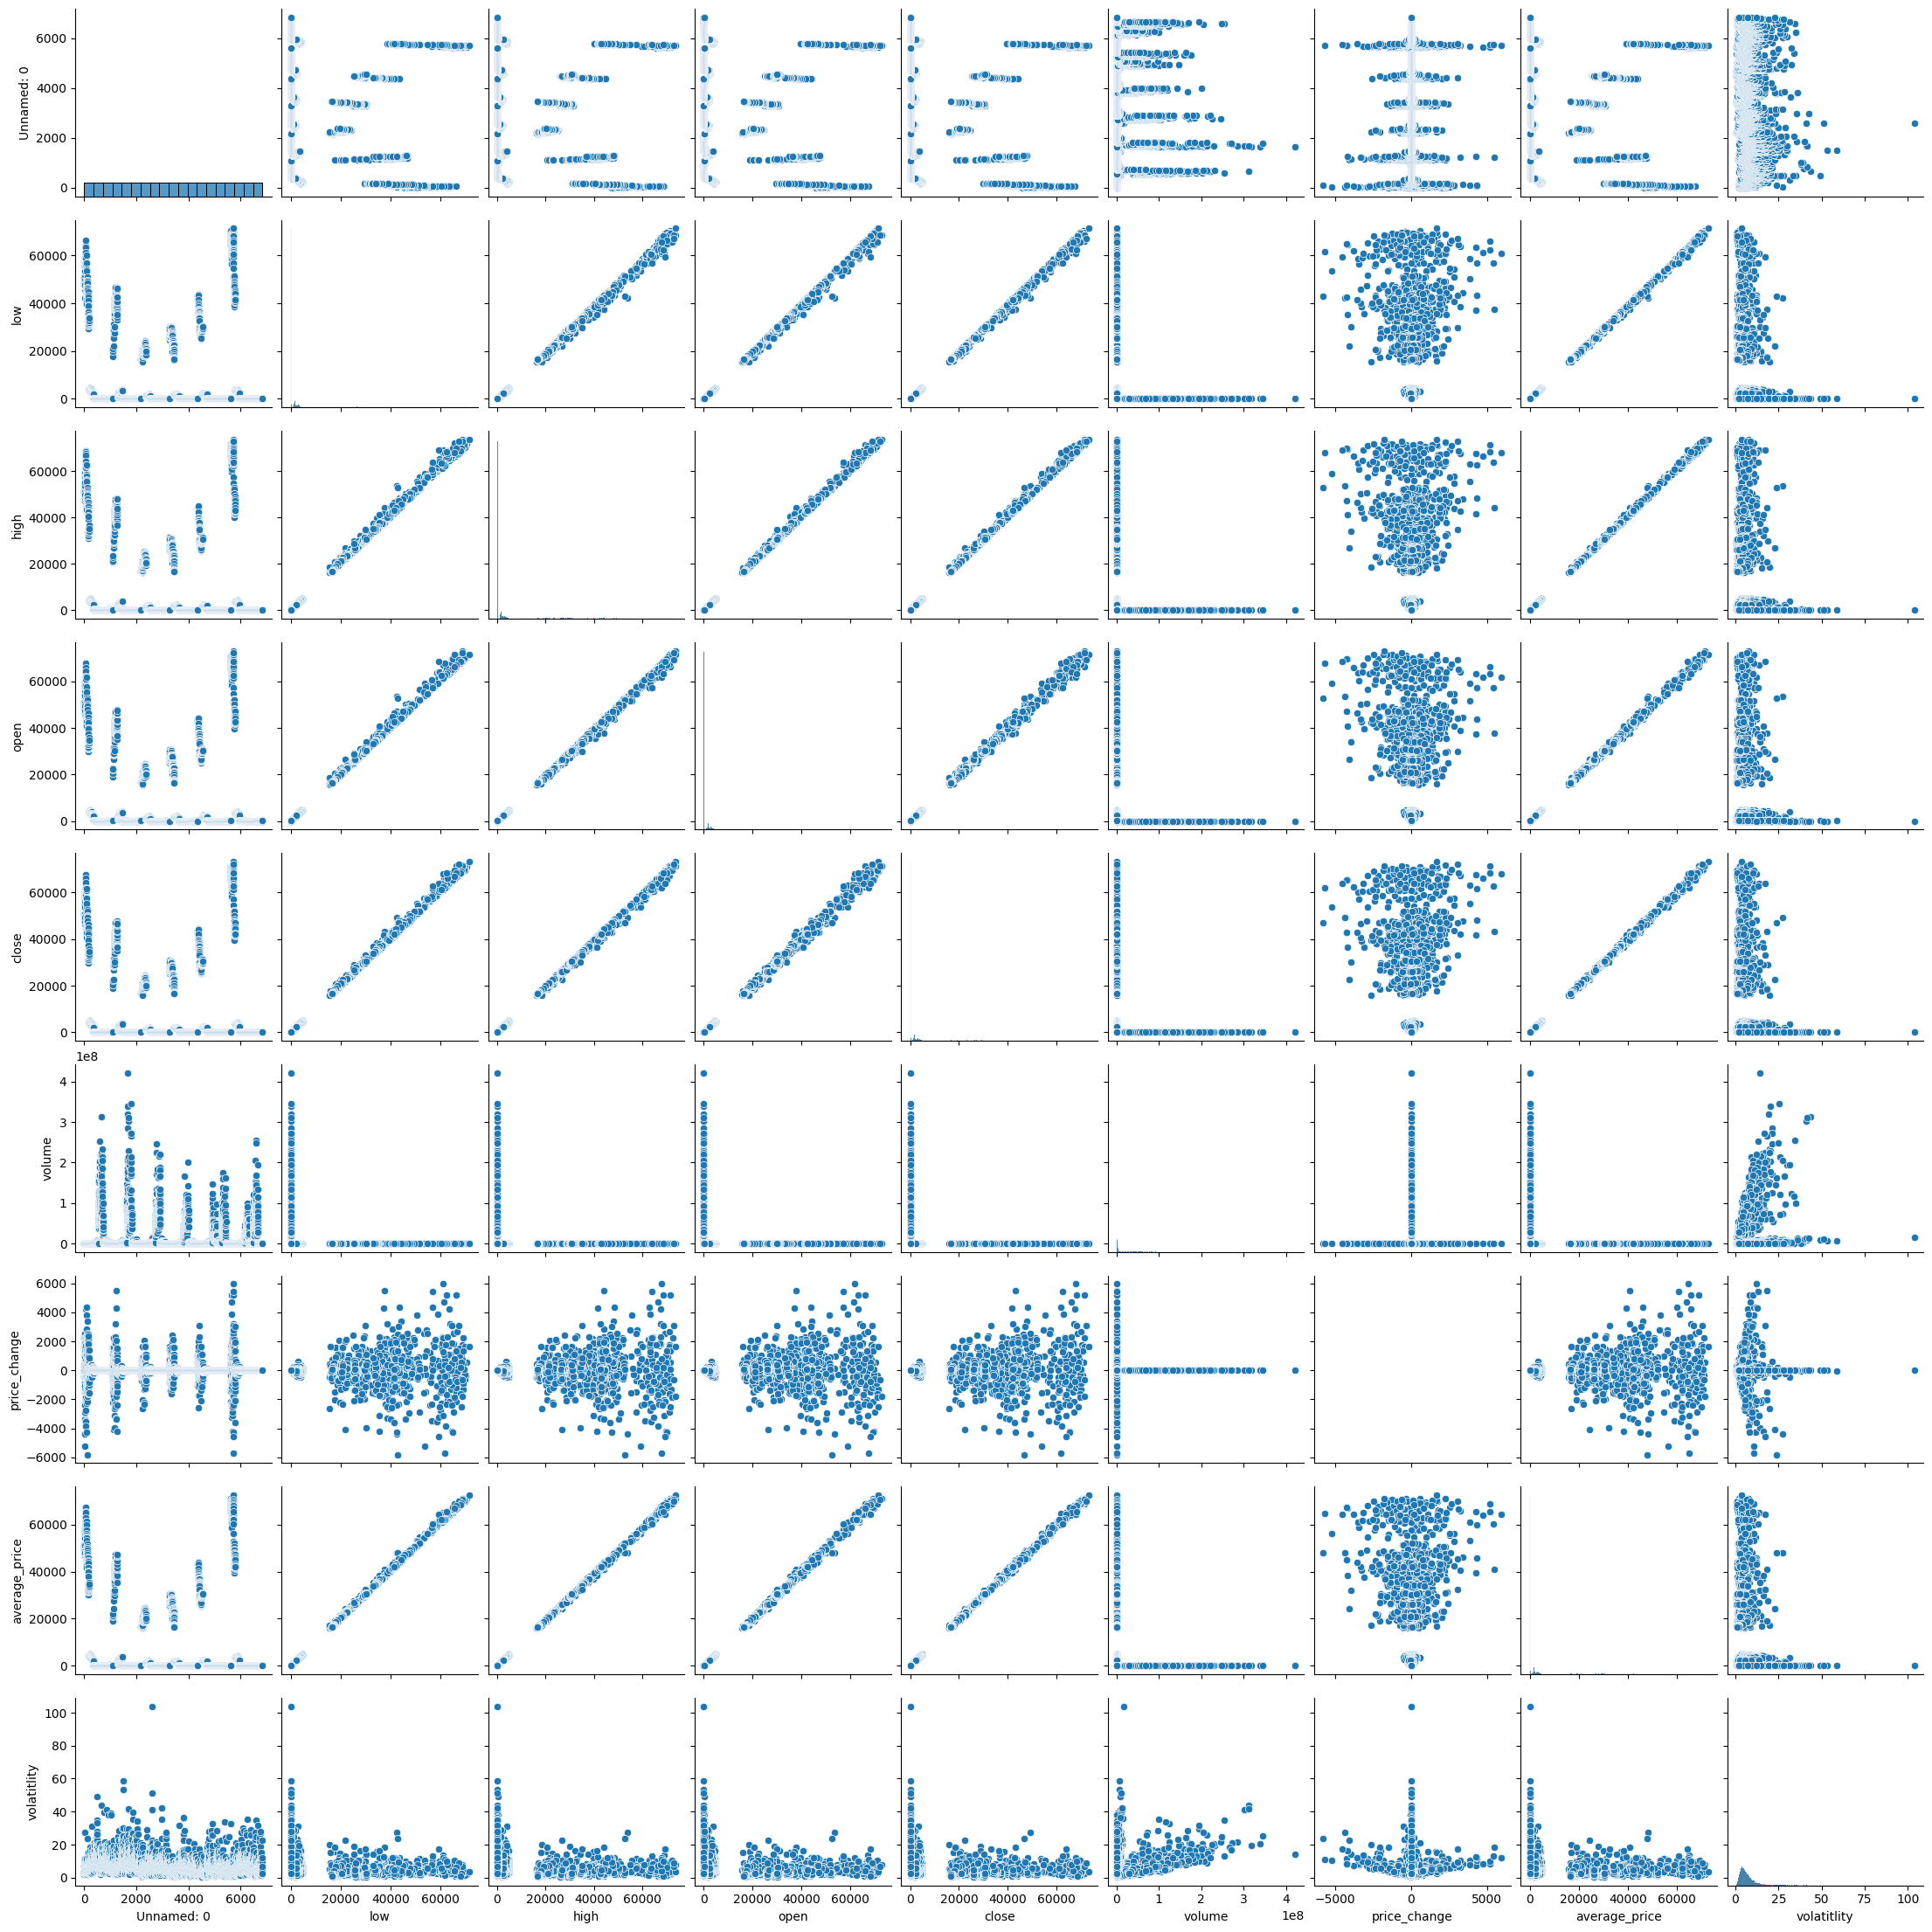

In [18]:
# Scatter plot matrix
sns.pairplot(data)
plt.show()

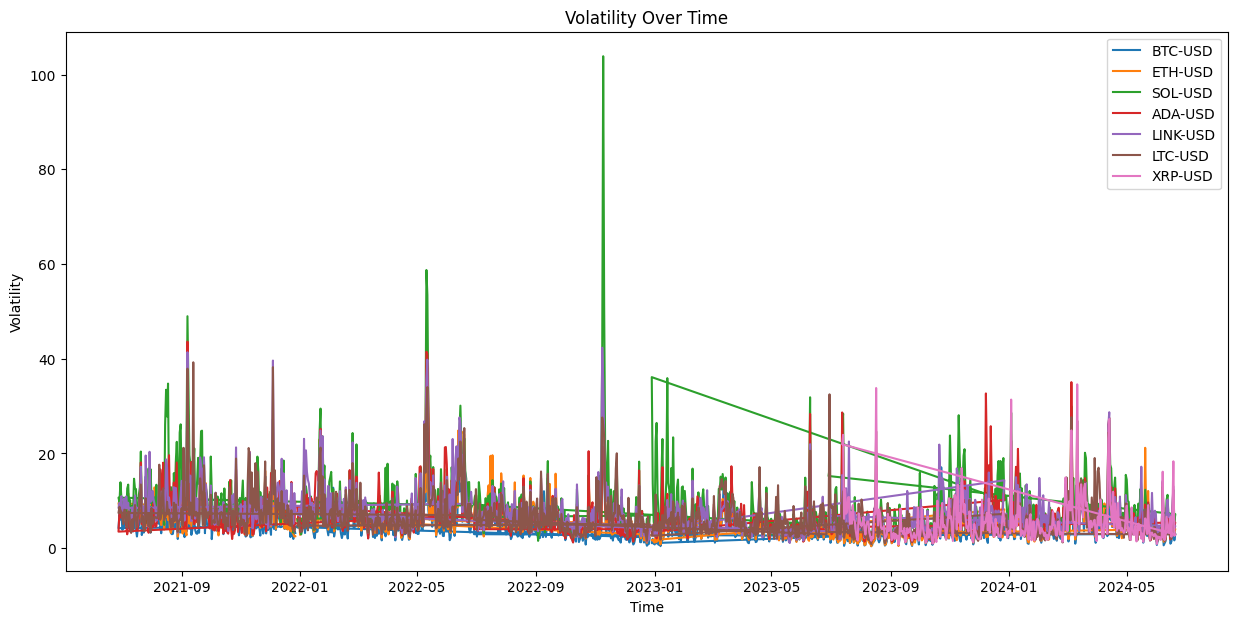

In [20]:
# Volatility over time
plt.figure(figsize=(15, 7))
for product in data['product_id'].unique():
    product_data = data[data['product_id'] == product]
    plt.plot(product_data['time'], product_data['volatitlity'], label=product)
plt.title('Volatility Over Time')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

#### Data Preprocessing

In [25]:
data

,time,low,high,open,close,volume,price_change,average_price,volatitlity,product_id
0,2021-12-27,50480.00,52100.00,50804.33,50717.77,11596.914682,-86.56,51290.000,3.209192,BTC-USD
1,2021-12-26,49460.00,51295.33,50428.31,50801.79,6863.394738,373.48,50377.665,3.710736,BTC-USD
2,2021-12-25,50191.84,51171.68,50852.31,50428.31,5550.571532,-424.00,50681.760,1.952190,BTC-USD
3,2021-12-24,50445.55,51878.60,50842.06,50851.38,11690.454182,9.32,51162.075,2.840786,BTC-USD
4,2021-12-23,48032.16,51397.82,48608.61,50842.20,16627.046280,2233.59,49714.990,7.007097,BTC-USD
...,...,...,...,...,...,...,...,...,...,...
6842,2024-01-02,72.50,75.94,74.75,72.98,163486.587394,-1.77,74.220,4.744828,LTC-USD
6843,2024-01-01,72.05,74.83,72.81,74.75,112009.560933,1.94,73.440,3.858432,LTC-USD
6844,2023-12-31,71.45,74.21,73.24,72.80,117693.683399,-0.44,72.830,3.862841,LTC-USD
6845,2023-12-30,72.38,73.99,73.21,73.23,175907.481069,0.02,73.185,2.224371,LTC-USD


In [24]:
# Drop the 'Unnamed: 0' column if it's not useful
data.drop(columns=['Unnamed: 0'], inplace=True)

In [26]:
# Feature Engineering: Create moving averages and lag features
data['moving_avg_7'] = data['close'].rolling(window=7).mean()
data['moving_avg_30'] = data['close'].rolling(window=30).mean()

In [27]:
# Create lag features
for lag in range(1, 8):
    data[f'lag_{lag}'] = data['close'].shift(lag)

In [28]:
# Drop rows with NaN values created by rolling and shifting
data.dropna(inplace=True)

In [29]:
# Select features and target
features = data.drop(columns=['time', 'product_id', 'close'])
target = data['close']

In [30]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shape of the training and test sets
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (5454, 16)
Test set shape: (1364, 16)


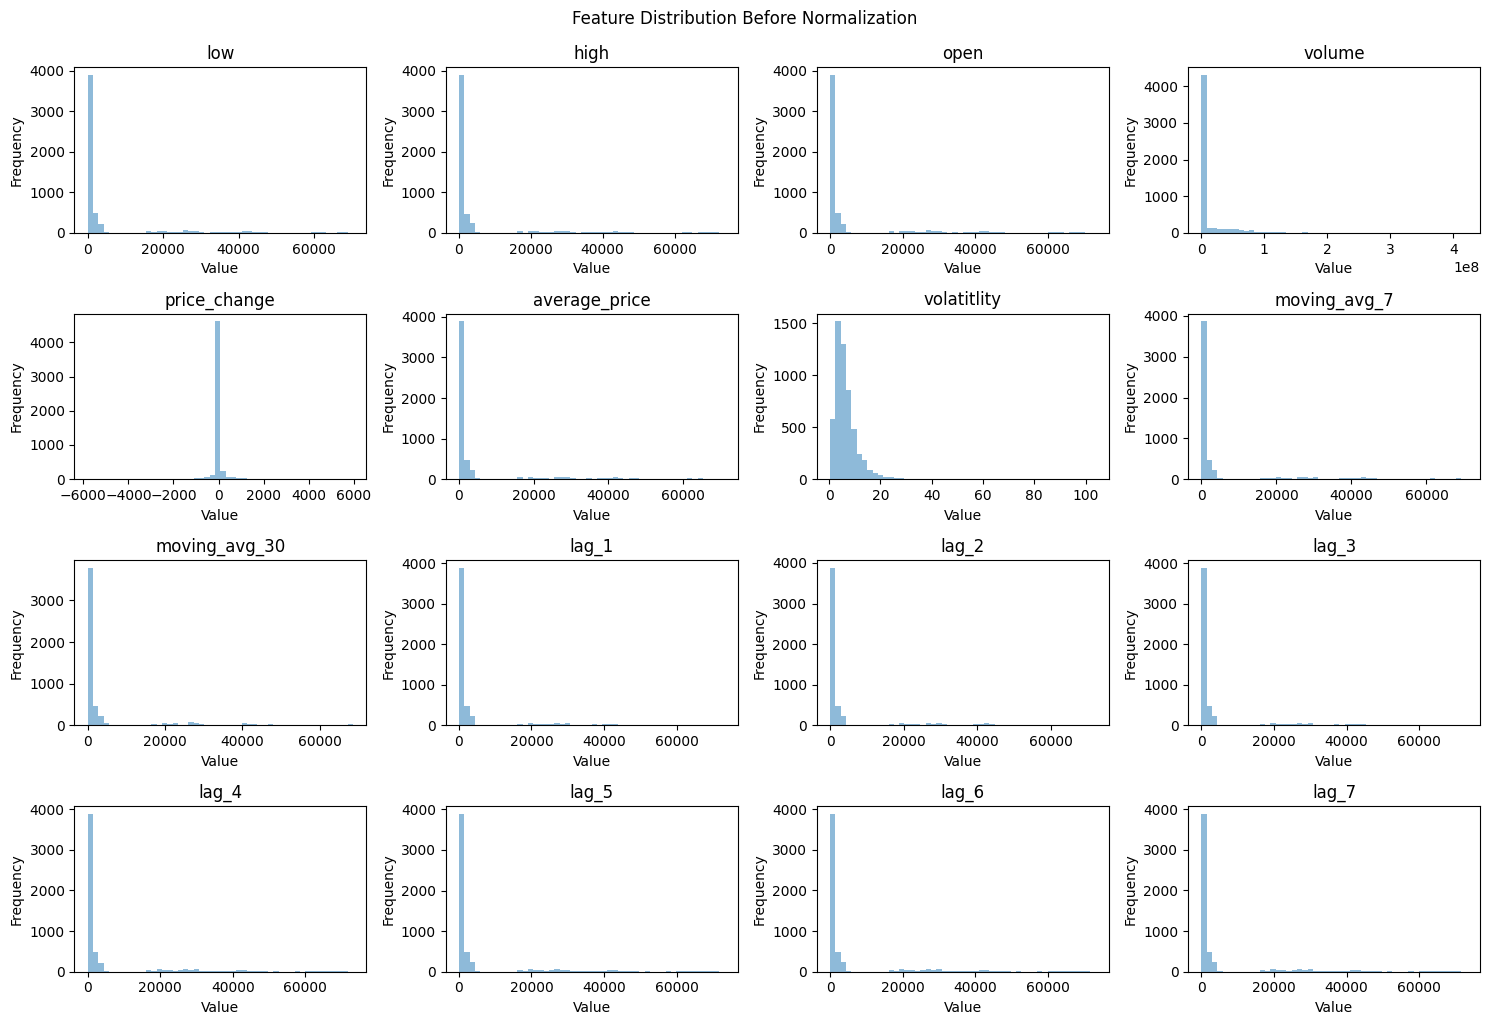

In [31]:
# Convert the scaled features back to a DataFrame for easier plotting
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features.columns)

# Plot the distribution of features before normalization
plt.figure(figsize=(15, 10))
for i, column in enumerate(features.columns, 1):
    plt.subplot(4, 4, i)
    plt.hist(X_train[column], bins=50, alpha=0.5, label='Original')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.suptitle('Feature Distribution Before Normalization', y=1.02)
plt.show()


#### Model Training

##### Baseline Model: Linear Regression

In [33]:
# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression MAE: {mae_lr}')
print(f'Linear Regression RMSE: {rmse_lr}')
print(f'Linear Regression R-squared: {r2_lr}')

Linear Regression MAE: 7.85780592597617e-12
Linear Regression RMSE: 1.3322770798215678e-11
Linear Regression R-squared: 1.0


##### Advanced Model: Random Forest

In [38]:
# Train a Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest MAE: {mae_rf}')
print(f'Random Forest RMSE: {rmse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  15.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  15.5s
[CV] END max

##### Advanced Model: Gradient Boosting

In [37]:
# Train a Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluate the Gradient Boosting model
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting MAE: {mae_gb}')
print(f'Gradient Boosting RMSE: {rmse_gb}')
print(f'Gradient Boosting R-squared: {r2_gb}')

Gradient Boosting MAE: 65.10090782167755
Gradient Boosting RMSE: 188.95930306339116
Gradient Boosting R-squared: 0.9998291482061337


#### Model Evaluation

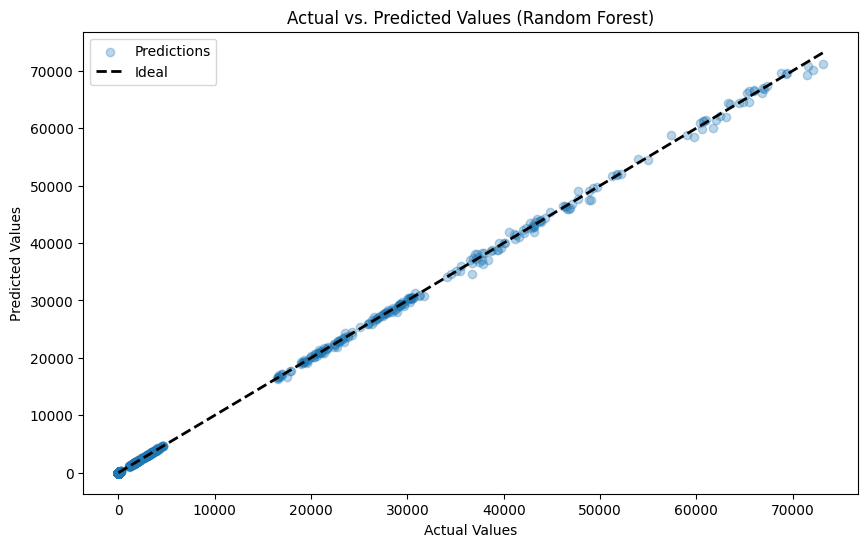

In [39]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Random Forest)')
plt.legend()
plt.show()

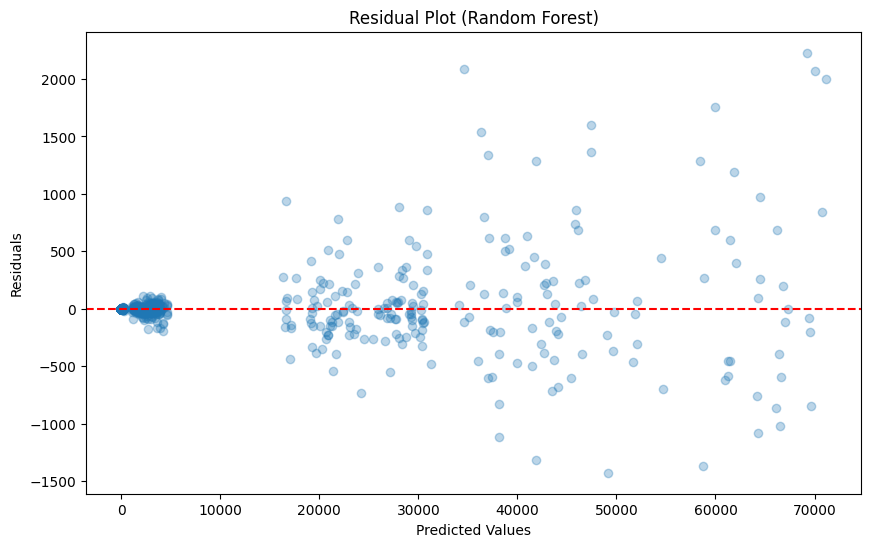

In [40]:
# Plot residuals
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Random Forest)')
plt.show()

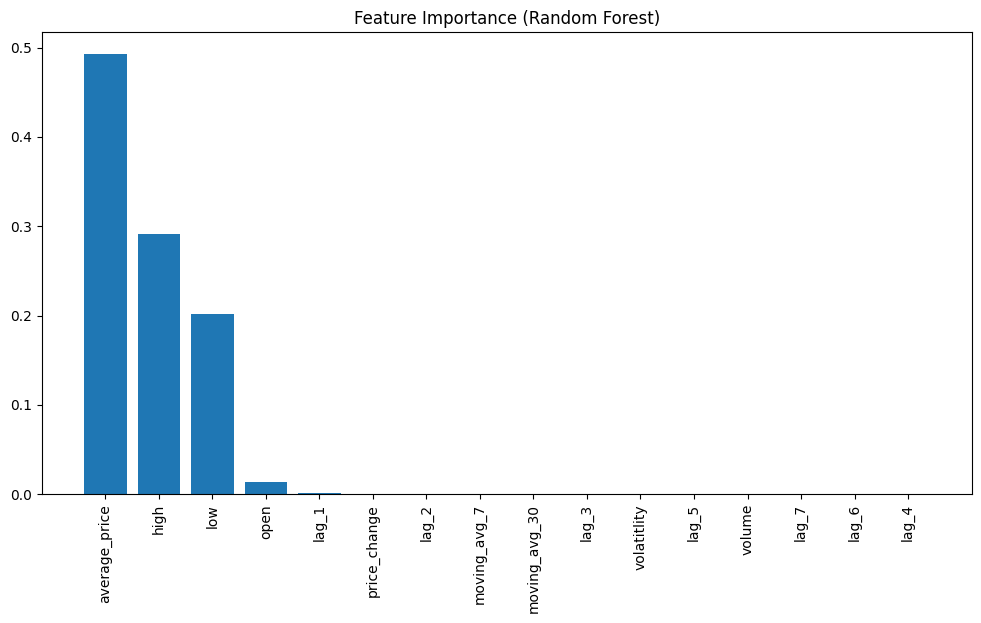

In [43]:
# Feature importance
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features.columns[i] for i in indices], rotation=90)
plt.show()

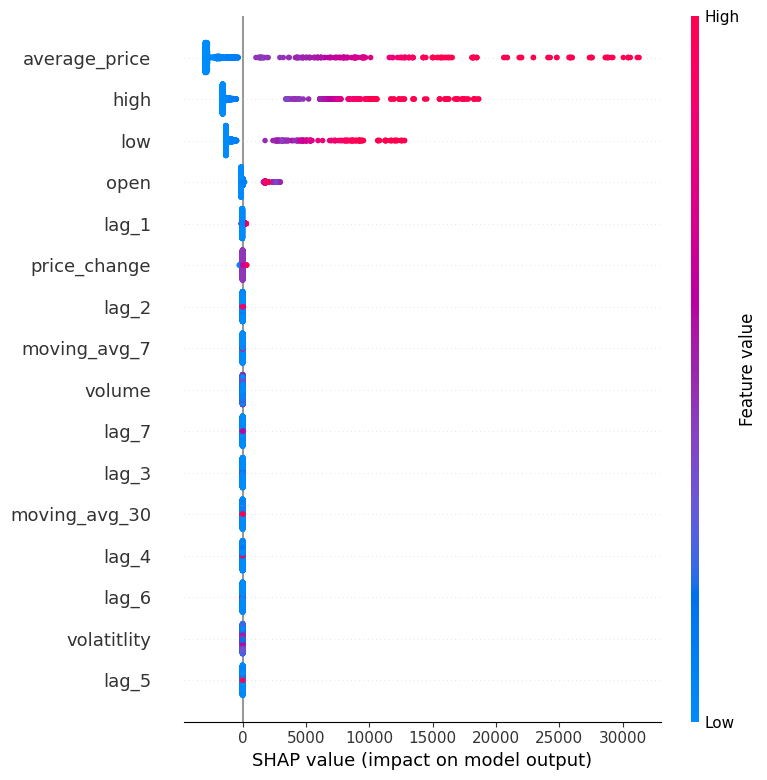

In [50]:
# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=features.columns)

##### Comparison of Models

In [51]:
# Initialize a dictionary to store the results
results = {}
results['Linear Regression'] = {'MAE': mae_lr, 'RMSE': rmse_lr, 'R-squared': r2_lr}
results['Random Forest'] = {'MAE': mae_rf, 'RMSE': rmse_rf, 'R-squared': r2_rf}
results['Gradient Boosting'] = {'MAE': mae_gb, 'RMSE': rmse_gb, 'R-squared': r2_gb}

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)

                            MAE          RMSE  R-squared
Linear Regression  7.857806e-12  1.332277e-11   1.000000
Random Forest      6.686660e+01  2.279717e+02   0.999751
Gradient Boosting  6.510091e+01  1.889593e+02   0.999829


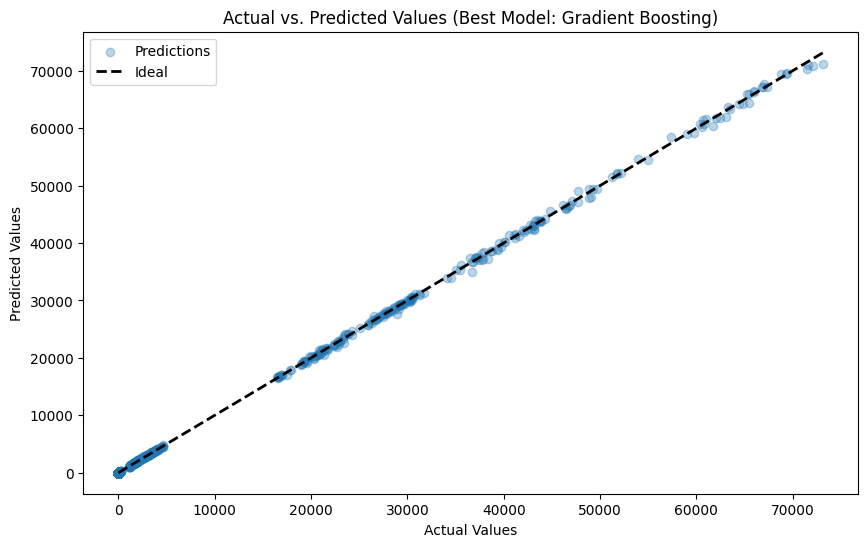

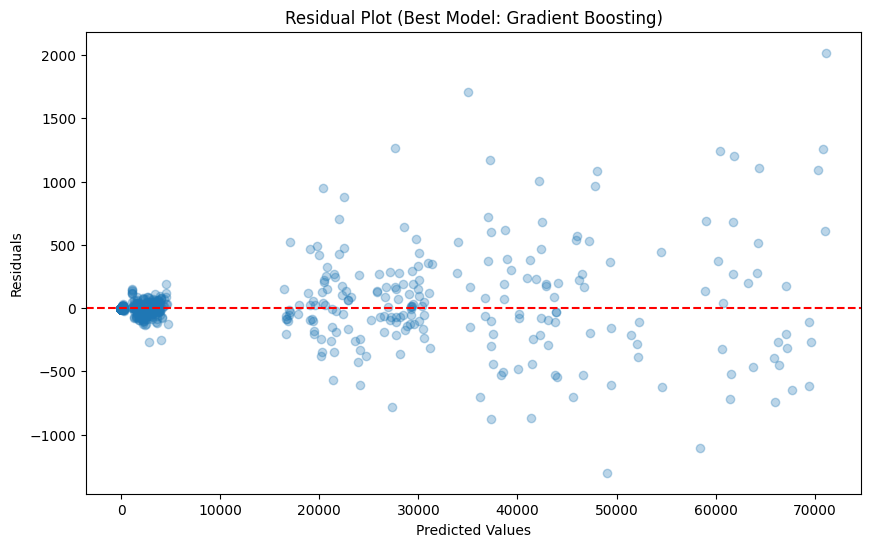

In [55]:
# Plot actual vs. predicted values for Gradient Boosting
y_pred_best = y_pred_gb  # Predictions from the best model (Gradient Boosting)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Best Model: Gradient Boosting)')
plt.legend()
plt.show()

# Plot residuals for Gradient Boosting
residuals_best = y_test - y_pred_best
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals_best, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Best Model: Gradient Boosting)')
plt.show()


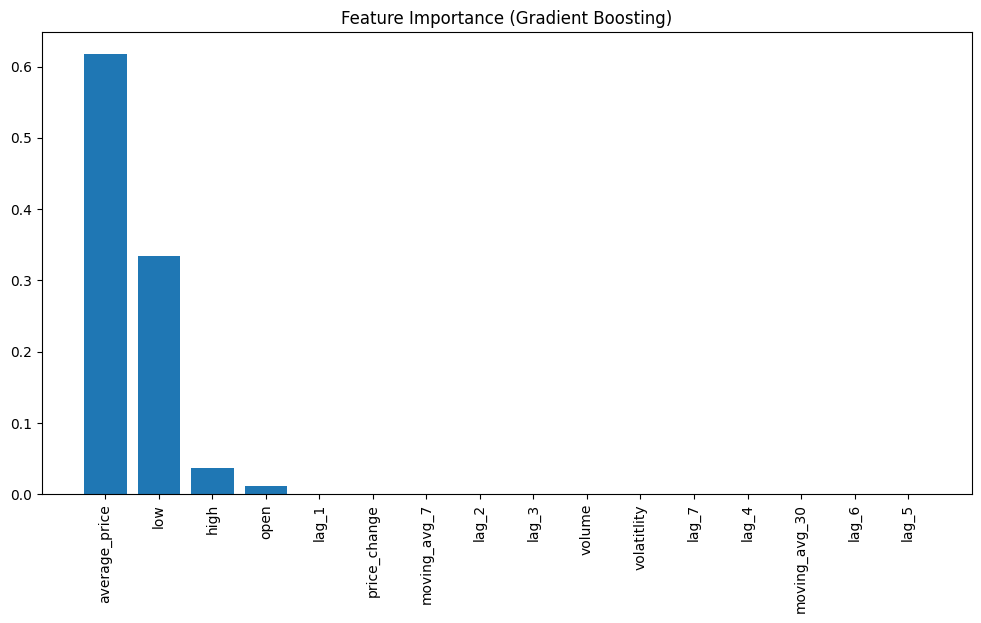

In [56]:
# Feature importance for the best model (Gradient Boosting)
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Gradient Boosting)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features.columns[i] for i in indices], rotation=90)
plt.show()


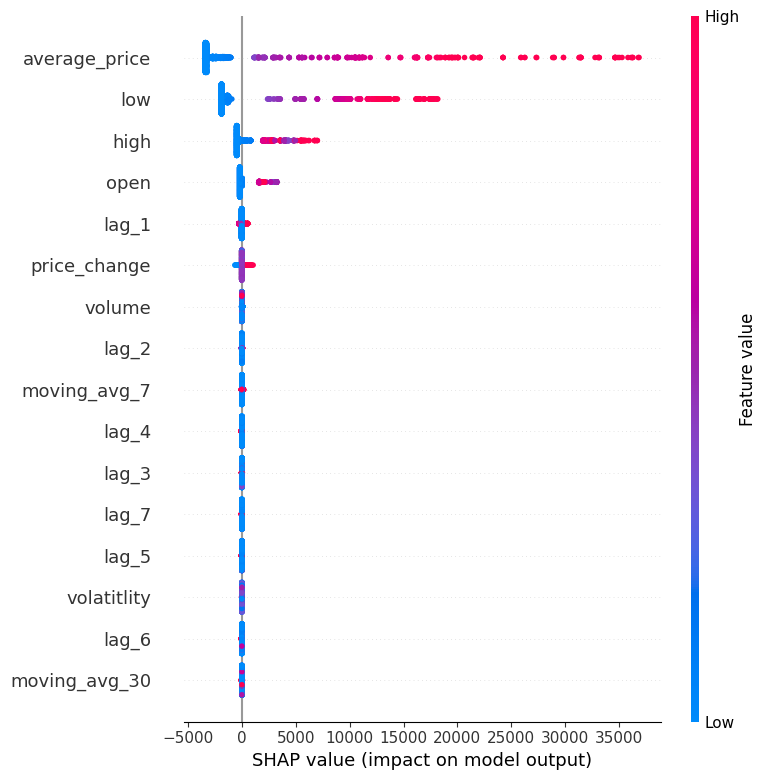

In [57]:
# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=features.columns)
